In [1]:
import os, sys
root_path = os.path.abspath('.').split('jupyters')[0]
sys.path.append(root_path)

In [2]:
import json
import argparse
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from models.cnn_geo import CNN_geo, Spatial_transformer_regressor
from functools import partial
import simulator as sim

In [3]:
def gen_motion_parameter(shape):
    while True:
        yield (tf.random.uniform(shape) - 0.5) * 2 * 0.2

In [4]:
gen = partial(gen_motion_parameter, (9,2))
ds = tf.data.Dataset.from_generator(gen, output_types=tf.float32)

In [5]:
def data_process(motion_parameters, axay, map_size):
    motion_parameters = motion_parameters.numpy()
    bxby = sim.get_tgt_from_src(motion_parameters, axay, map_size)
    axybxy = np.concatenate([axay, bxby], axis = -1)
    correlations = sim.generate_correlations(axybxy, map_size)
    return motion_parameters, correlations

In [6]:
axay = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
map_size = (16, 16)
axay = axay*(map_size[1]-1, map_size[0]-1)
axay = axay.astype(np.int32)

py_func = partial(data_process, axay = axay, map_size = map_size)

In [7]:
def map_function(motion_paramters):
    return tf.py_function(py_func, [motion_paramters], [tf.float32, tf.float32])

In [8]:
ds = ds.map(map_function)
ds = ds.batch(16)

In [9]:
for mp, corr in ds.take(1):
    print(mp.shape)
    print(corr.shape)

(16, 9, 2)
(16, 16, 16, 16, 16)


In [10]:
regressor = Spatial_transformer_regressor(18)

In [11]:
def loss_fn(pred, label):
    loss = tf.sqrt(tf.reduce_sum(tf.pow(pred - label, 2), axis=[-1, -2]))
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [12]:
i = 0
x = []
x_loss = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
for epoch in range(20000):
    i+= 1
    x.append(i)
    for mp, correlations in ds.take(1):
        with tf.GradientTape() as tape:
            pred = regressor(correlations)
            pred = tf.reshape(pred, [-1, 9, 2])
            loss = loss_fn(pred, mp)
            x_loss.append(loss)
        gradients = tape.gradient(loss, regressor.trainable_variables)
        optimizer.apply_gradients(zip(gradients, regressor.trainable_variables)) 
        if i % 100 == 0:
            print(i, "iter loss : ", loss.numpy())

100 iter loss :  0.48646435
200 iter loss :  0.47916144
300 iter loss :  0.4988487
400 iter loss :  0.49012113
500 iter loss :  0.5022621
600 iter loss :  0.5010421
700 iter loss :  0.49674267
800 iter loss :  0.47573024
900 iter loss :  0.4959175
1000 iter loss :  0.470406
1100 iter loss :  0.48297694
1200 iter loss :  0.4571879
1300 iter loss :  0.48452872
1400 iter loss :  0.4930817
1500 iter loss :  0.46771586
1600 iter loss :  0.46938545
1700 iter loss :  0.47790682
1800 iter loss :  0.47635692
1900 iter loss :  0.46694943
2000 iter loss :  0.46624205
2100 iter loss :  0.47062826
2200 iter loss :  0.46383667
2300 iter loss :  0.4451822
2400 iter loss :  0.45891327
2500 iter loss :  0.4425953
2600 iter loss :  0.45269674
2700 iter loss :  0.4506942
2800 iter loss :  0.4649723
2900 iter loss :  0.46354407
3000 iter loss :  0.4539291
3100 iter loss :  0.4548511
3200 iter loss :  0.45807427
3300 iter loss :  0.42976934
3400 iter loss :  0.46049792
3500 iter loss :  0.44432336
3600 ite

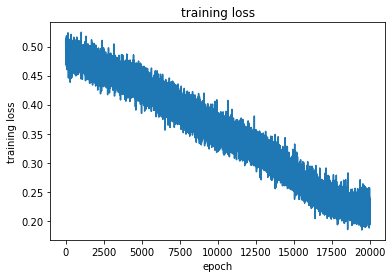

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1.title.set_text("training loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("training loss")
ax1.plot(np.array(x), np.array(x_loss))

# ax2.title.set_text("std-dev of correlations")
# ax2.set_xlabel("epoch")
# ax2.set_ylabel("std-dev")
# ax2.plot(np.array(x), np.array(y_score_std))

In [14]:
from utils import image, visualize

In [17]:
bordersize = 20
N = 16
for mp, correlations in ds.take(1):
    pred = regressor(correlations)
    pred = tf.reshape(pred, [-1, 9, 2])

mp = mp.numpy()
print(mp.shape)
pred = pred.numpy()
print(pred.shape)

white_board = np.ones([N,64+2*bordersize,64+2*bordersize,3], np.float32)
motion_parameters = np.array(list(map(lambda image, mp : visualize.draw_arrow(image,bordersize,mp) 
                                     ,white_board, mp)))
predictions = np.array(list(map(lambda image, parameter : visualize.draw_arrow(image,bordersize,parameter) 
                                         ,white_board, pred)))

images = np.stack([motion_parameters, predictions], axis=1)

(16, 9, 2)
(16, 9, 2)


In [33]:
def show_image(images, figsize=(20, 100)):
    rows, cols = images.shape[:2]
    fig = plt.figure(figsize=figsize)
    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        image = images[row][col]
        fig.add_subplot(rows, cols, i + 1).imshow(image)
    plt.show()

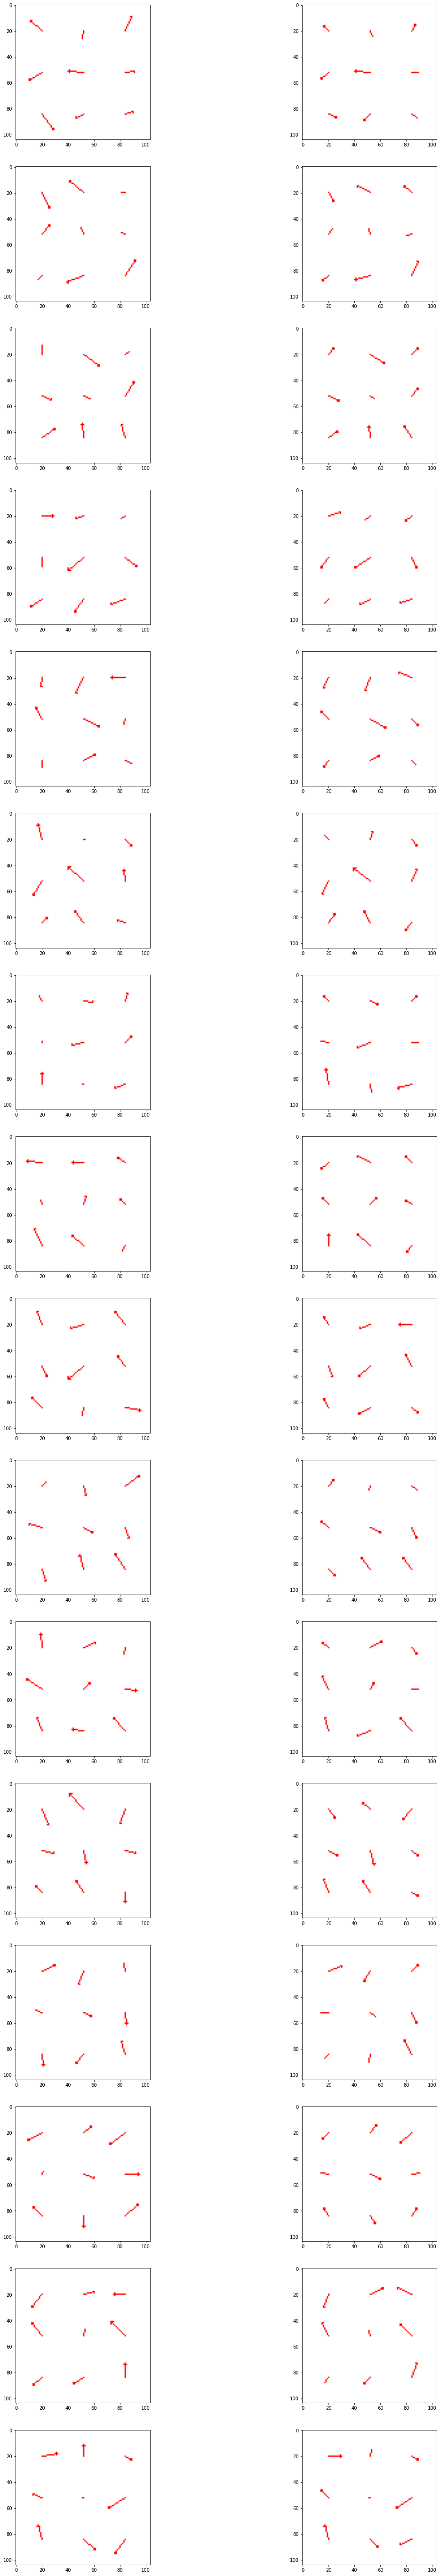

In [34]:
show_image(images)

# Training more and change learning rate

In [15]:
x = []
x_loss = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
for epoch in range(20000):
    i+= 1
    x.append(i)
    for mp, correlations in ds.take(1):
        with tf.GradientTape() as tape:
            pred = regressor(correlations)
            pred = tf.reshape(pred, [-1, 9, 2])
            loss = loss_fn(pred, mp)
            x_loss.append(loss)
        gradients = tape.gradient(loss, regressor.trainable_variables)
        optimizer.apply_gradients(zip(gradients, regressor.trainable_variables)) 
        if i % 100 == 0:
            print(i, "iter loss : ", loss.numpy())

20100 iter loss :  0.2374729
20200 iter loss :  0.22262985
20300 iter loss :  0.21556354
20400 iter loss :  0.23469731
20500 iter loss :  0.2148498
20600 iter loss :  0.21814314
20700 iter loss :  0.22442773
20800 iter loss :  0.21857516
20900 iter loss :  0.22869805
21000 iter loss :  0.21166317
21100 iter loss :  0.23177499
21200 iter loss :  0.21156915
21300 iter loss :  0.2214749
21400 iter loss :  0.22012213
21500 iter loss :  0.20719472
21600 iter loss :  0.20319337
21700 iter loss :  0.20400316
21800 iter loss :  0.21340023
21900 iter loss :  0.21535689
22000 iter loss :  0.21087441
22100 iter loss :  0.19513072
22200 iter loss :  0.20228948
22300 iter loss :  0.22795828
22400 iter loss :  0.21632868
22500 iter loss :  0.21533869
22600 iter loss :  0.21302697
22700 iter loss :  0.21417364
22800 iter loss :  0.20844454
22900 iter loss :  0.22659487
23000 iter loss :  0.19249186
23100 iter loss :  0.21892522
23200 iter loss :  0.22243379
23300 iter loss :  0.20381536
23400 iter lo

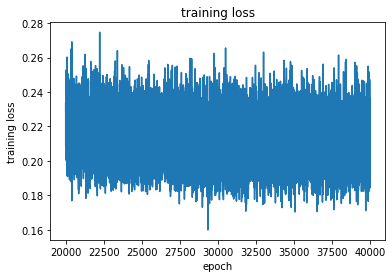

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1.title.set_text("training loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("training loss")
ax1.plot(np.array(x), np.array(x_loss))

# ax2.title.set_text("std-dev of correlations")
# ax2.set_xlabel("epoch")
# ax2.set_ylabel("std-dev")
# ax2.plot(np.array(x), np.array(y_score_std))

In [17]:
x = []
x_loss = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
for epoch in range(20000):
    i+= 1
    x.append(i)
    for mp, correlations in ds.take(1):
        with tf.GradientTape() as tape:
            pred = regressor(correlations)
            pred = tf.reshape(pred, [-1, 9, 2])
            loss = loss_fn(pred, mp)
            x_loss.append(loss)
        gradients = tape.gradient(loss, regressor.trainable_variables)
        optimizer.apply_gradients(zip(gradients, regressor.trainable_variables)) 
        if i % 100 == 0:
            print(i, "iter loss : ", loss.numpy())

40100 iter loss :  0.22739604
40200 iter loss :  0.21820572
40300 iter loss :  0.21363264
40400 iter loss :  0.20805939
40500 iter loss :  0.21957815
40600 iter loss :  0.2022327
40700 iter loss :  0.20510727
40800 iter loss :  0.21470425
40900 iter loss :  0.24120781
41000 iter loss :  0.1949597
41100 iter loss :  0.21153572
41200 iter loss :  0.18609458
41300 iter loss :  0.20558469
41400 iter loss :  0.20888291
41500 iter loss :  0.19729498
41600 iter loss :  0.20114234
41700 iter loss :  0.21992655
41800 iter loss :  0.20823932
41900 iter loss :  0.20997265
42000 iter loss :  0.22259411
42100 iter loss :  0.20096397
42200 iter loss :  0.22191867
42300 iter loss :  0.21300426
42400 iter loss :  0.21424651
42500 iter loss :  0.18576592
42600 iter loss :  0.1904056
42700 iter loss :  0.24717146
42800 iter loss :  0.22062984
42900 iter loss :  0.20854253
43000 iter loss :  0.19214538
43100 iter loss :  0.22109157
43200 iter loss :  0.21592522
43300 iter loss :  0.2216109
43400 iter los

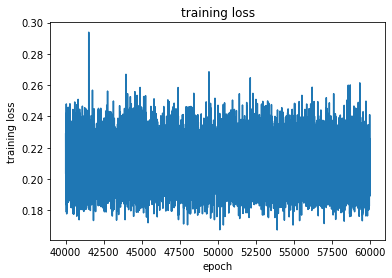

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1.title.set_text("training loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("training loss")
ax1.plot(np.array(x), np.array(x_loss))

# ax2.title.set_text("std-dev of correlations")
# ax2.set_xlabel("epoch")
# ax2.set_ylabel("std-dev")
# ax2.plot(np.array(x), np.array(y_score_std))

In [23]:
for mp, corr in ds.take(1):
    pred = regressor(corr)
    pred = tf.reshape(pred, [-1, 9, 2])

In [36]:
pred[0]

<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[ 0.1883005 ,  0.1433503 ],
       [ 0.00413249, -0.10001589],
       [ 0.08948354, -0.06716209],
       [-0.09269941,  0.06156114],
       [-0.14597961,  0.13638309],
       [-0.05778319, -0.07614674],
       [-0.06821522, -0.07332332],
       [-0.1127115 ,  0.07403905],
       [ 0.0797099 ,  0.08333907]], dtype=float32)>

In [37]:
mp[0]

<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[ 0.17069522,  0.16263328],
       [-0.03232708, -0.13009273],
       [ 0.0748085 , -0.09620815],
       [-0.05732775,  0.02519917],
       [-0.15379277,  0.1483715 ],
       [-0.0596693 , -0.09356704],
       [-0.05032959, -0.12859593],
       [-0.03580518,  0.13290448],
       [ 0.05473471, -0.02192111]], dtype=float32)>

In [38]:
tf.sqrt(tf.reduce_sum(tf.pow(pred[0] - mp[0], 2), axis=[-1, -2]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.17753312>

In [39]:
pred[0]*mp[0] > 0

<tf.Tensor: shape=(9, 2), dtype=bool, numpy=
array([[ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True, False]])>

In [ ]:
def loss_fn(pred, label):
    loss = tf.sqrt(tf.reduce_sum(tf.pow(pred - label, 2), axis=[-1, -2]))
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

# Smaller grid map

In [ ]:
map_size = (3,3)

In [ ]:
gen = partial(gen_motion_parameter, (9,2))
ds = tf.data.Dataset.from_generator(gen, output_types=tf.float32)